# 110 Preparing robot pose information

In [1]:
load_from_config = True
raw_data_folder = ""
preprocessed_data_folder = ""

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import math
import yaml

from geopy.distance import geodesic
import folium

In [3]:
with open('../config.yaml') as file:
  params= yaml.safe_load(file)

# in case of a automatic run
if not load_from_config:
    params['raw_data_folder'] = raw_data_folder
    params['preprocessed_data_folder'] = preprocessed_data_folder

data_folder = params['data_folder'] + params['raw_data_folder']

## Adding uncertainty to the robot pose

In [4]:


df_gnss = pd.read_csv(data_folder + 'gnss.csv')
df_gnss['timestamp'] = pd.to_datetime(df_gnss['timestamp'], unit='ns')

http://docs.ros.org/en/noetic/api/sensor_msgs/html/msg/NavSatFix.html

```
# If the covariance of the fix is known, fill it in completely. If the
# GPS receiver provides the variance of each measurement, put them
# along the diagonal. If only Dilution of Precision is available,
# estimate an approximate covariance from that.

uint8 COVARIANCE_TYPE_UNKNOWN = 0
uint8 COVARIANCE_TYPE_APPROXIMATED = 1
uint8 COVARIANCE_TYPE_DIAGONAL_KNOWN = 2
uint8 COVARIANCE_TYPE_KNOWN = 3

uint8 position_covariance_type
```

In [5]:
df_gnss['position_covariance_type'].value_counts()

position_covariance_type
1    3374
Name: count, dtype: int64

In [6]:
df_gnss['PDOP']= 0.
df_gnss['HDOP']= 0.
df_gnss['VDOP']= 0.

for index, row in df_gnss.iterrows():
    C = np.array([[row['position_covariance.0'], row['position_covariance.1'], row['position_covariance.2']],
                  [row['position_covariance.3'], row['position_covariance.4'], row['position_covariance.5']],
                  [row['position_covariance.6'], row['position_covariance.7'], row['position_covariance.8']]])
    df_gnss.at[index, 'PDOP'] = np.sqrt(np.trace(C))
    df_gnss.at[index, 'HDOP'] = np.sqrt(np.trace(C[:2, :2]))
    df_gnss.at[index, 'VDOP'] = np.sqrt(C[2, 2])

## Approximate orientation by gnss points

In [7]:
df_gnss['latitude_pre'] = df_gnss['latitude'].shift(1)
df_gnss['longitude_pre'] = df_gnss['longitude'].shift(1)
df_gnss['time_diff'] = df_gnss.index.to_series().diff()

# Function to calculate Haversine distance between two points
def haversine_distance(coord1, coord2, time_diff, time_diff_threshold=1.5):
    if np.isnan(coord1[0]) | np.isnan(coord1[1]) | np.isnan(coord2[0]) | np.isnan(coord2[1]):
        return np.nan
    if time_diff > time_diff_threshold:
        return np.nan
    return geodesic(coord1, coord2).meters

# Calculate distances between consecutive points
df_gnss['distance'] = df_gnss.apply(lambda row: haversine_distance((row['latitude'], row['longitude']),
                                                                   (row['latitude_pre'], row['longitude_pre']),
                                                                    row['time_diff']), axis=1)

df_gnss['speed'] = df_gnss['distance'] / df_gnss['time_diff']

Text(0.5, 0, 'Speed (m/s)')

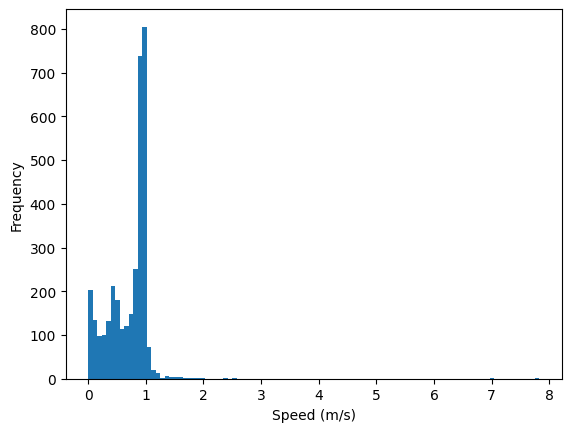

In [8]:
df_gnss['speed'].plot.hist(bins=100)
plt.xlabel('Speed (m/s)')

In [9]:
# Calculate bearing between consecutive points
def calculate_bearing(coord1, coord2):
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    d_lon = lon2 - lon1

    x = np.sin(d_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)

    return np.arctan2(x, y) + np.pi

df_gnss['bearing'] = df_gnss.apply(lambda row: calculate_bearing((row['latitude'], row['longitude']),
                                                                 (row['latitude_pre'], row['longitude_pre'])),
                          axis=1)

In [10]:
df_gnss['bearing'].min()

0.0011876002575750277

In [11]:
def shift_position(latitude, longitude, angle_in_rad, distance_m):
    earth_radius_km = 6371.0  # Average Earth radius in kilometers

    distance_km = distance_m / 1000

    # Calculate new latitude and longitude
    new_latitude = math.degrees(math.asin(math.sin(math.radians(latitude)) * math.cos(distance_km / earth_radius_km) +
                                          math.cos(math.radians(latitude)) * math.sin(distance_km / earth_radius_km) * math.cos(angle_in_rad)))

    new_longitude = math.degrees(math.radians(longitude) + math.atan2(math.sin(angle_in_rad) * math.sin(distance_km / earth_radius_km) * math.cos(math.radians(latitude)),
                                                                      math.cos(distance_km / earth_radius_km) - math.sin(math.radians(latitude)) * math.sin(math.radians(new_latitude))))

    return new_latitude, new_longitude

arrow_length = 5

df_gnss['latitude_dir']=np.nan
df_gnss['longitude_dir']=np.nan

for index, row in df_gnss.iterrows():
    new_lat, new_lon = shift_position(row['latitude'], row['longitude'], row['bearing'], row['speed'] * arrow_length)
    df_gnss.at[index, 'latitude_dir'] = new_lat
    df_gnss.at[index, 'longitude_dir'] = new_lon

Text(0.5, 0, 'rotational speed (rad/s)')

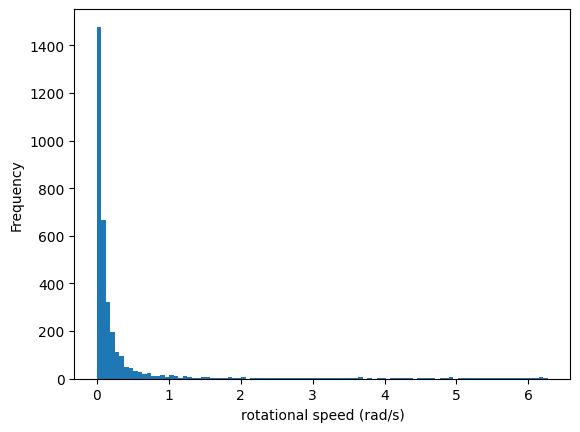

In [21]:
df_gnss['heading_diff'] = df_gnss['bearing'].diff().abs()
df_gnss['heading_diff'].plot.hist(bins=100)
plt.xlabel('rotational speed (rad/s)')

In [13]:
def check_validity(row):
    if row['status.status'] == 0:
        return False
    if row['HDOP'] > 1.3:
        return False
    if row['heading_diff'] > 0.4:
        return False
    if row['speed'] < 0.1 or row['speed'] > 1.5:
        return False
    return True

df_gnss['pose_valid'] = df_gnss.apply(check_validity, axis=1)

In [14]:
df_gnss[['status.status', 'HDOP', 'heading_diff', 'speed', 'pose_valid']].iloc[50]

status.status           2
HDOP             1.833606
heading_diff     0.690415
speed            0.080964
pose_valid          False
Name: 50, dtype: object

In [15]:
center = [df_gnss['latitude'].mean(), df_gnss['longitude'].mean()]

mymap = folium.Map(location=center, zoom_start=18, max_zoom=20, attr='osm.com')

n=2

# Marker für jede Zeile in GNSS-Daten hinzufügen
for index, row in df_gnss.iloc[n-1::n].iterrows():

    if row['pose_valid'] == True:
        color = 'green'
    else:
        color = 'red'
    folium.CircleMarker([row['latitude'], row['longitude']],
                         radius=4,
                         color=color).add_to(mymap)


   # if row['pose_valid'] == True:
    folium.PolyLine(locations=[[row['latitude'], row['longitude']],
                                   [row['latitude_dir'], 
                                    row['longitude_dir']]], color='blue').add_to(mymap)

# Karte anzeigen
mymap.save('map.html')
mymap


In [16]:
df_gnss.drop(['Unnamed: 0', 'COVARIANCE_TYPE_APPROXIMATED',
              'COVARIANCE_TYPE_DIAGONAL_KNOWN', 'COVARIANCE_TYPE_KNOWN',
              'COVARIANCE_TYPE_UNKNOWN',
              'position_covariance.0', 'position_covariance.1',
              'position_covariance.2', 'position_covariance.3',
              'position_covariance.4', 'position_covariance.5',
              'position_covariance.6', 'position_covariance.7', 'position_covariance.8',
              'status.SERVICE_COMPASS', 'status.SERVICE_GALILEO',
              'status.SERVICE_GLONASS', 'status.SERVICE_GPS', 'status.STATUS_FIX',
              'status.STATUS_GBAS_FIX', 'status.STATUS_NO_FIX',
              'status.STATUS_SBAS_FIX','latitude_pre', 'longitude_pre'], axis=1, inplace=True)

In [17]:
df_gnss.head(3).T

,0,1,2
altitude,442.483,442.438,442.419
header.frame_id,gps,gps,gps
header.stamp.nanosec,457864951,454002313,455562615
header.stamp.sec,1684917411,1684917412,1684917413
latitude,50.91822,50.91822,50.918219
longitude,13.341466,13.341466,13.341467
position_covariance_type,1,1,1
status.service,1,1,1
status.status,2,2,2
ros_type,2,2,2


In [18]:
preprocessed_data_folder = params['data_folder'] + params['preprocessed_data_folder']
pd.to_pickle(df_gnss, preprocessed_data_folder + params['preprocessed_file_labels']+ "robot.pkl")